The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_temp/convergence_analysis_s11/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


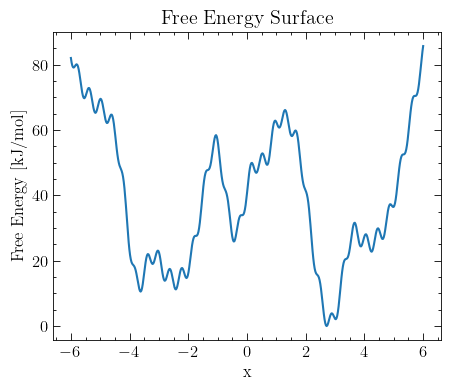

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_temp/convergence_analysis_s11/"): print("\nThe data folder \"_data_temp/convergence_analysis_s11/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_temp/convergence_analysis_s11/"); 
    path_data = path_notebook + "/_data_temp/convergence_analysis_s11/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 11
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

#### Define default parameters

In [12]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [2]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, #"dy":dy, # "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 1_000_000, 
					"position_pace":20, "metad_pace":200, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":2, "biasfactor":50 , 
         			"Bias_sf":1, "gaus_filter_sigma":None, 
                    "len_error_list":100, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":None, "record_forces_e":True, "save_error_progression":True,
     				"simulation_folder_path": path_data, "print_info": False}

### Run Long simulation for reference

In [3]:
# Run 100 long simulations
long_sim_params = {**default_params}

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,10):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class1D.MFI1D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index]
                
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, (AAD at 10% = {aad[10]:.4f})")
    if i_sim % 5 == 0: 
        aad_avr = np.mean(aad_collection, axis=0)
        print(f"--- Mean of final AAD: {aad_avr[-1]:.4f}, (10% = {aad_avr[10]:.4f})")       



Simulation 1 (exists) | Final Error: Aofe = 1.6306, AAD = 0.6511, (AAD at 10% = 11.1183)
Simulation 2 (exists) | Final Error: Aofe = 1.6700, AAD = 0.4317, (AAD at 10% = 12.4292)
Simulation 3 (exists) | Final Error: Aofe = 1.6674, AAD = 0.4397, (AAD at 10% = 10.9682)
Simulation 4 (exists) | Final Error: Aofe = 1.6693, AAD = 0.7869, (AAD at 10% = 10.9337)
Simulation 5 (exists) | Final Error: Aofe = 1.6668, AAD = 0.7167, (AAD at 10% = 17.9650)
--- Mean of final AAD: 0.6052, (10% = 12.6829)
Simulation 6 (exists) | Final Error: Aofe = 1.6543, AAD = 0.4540, (AAD at 10% = 12.6298)
Simulation 7 (exists) | Final Error: Aofe = 1.6344, AAD = 0.4541, (AAD at 10% = 15.3925)
Simulation 8 (exists) | Final Error: Aofe = 1.6829, AAD = 0.4663, (AAD at 10% = 15.3403)
Simulation 9 (exists) | Final Error: Aofe = 1.6760, AAD = 0.4873, (AAD at 10% = 12.6743)


Mean Final AAD: 0.5431 +- 0.0429


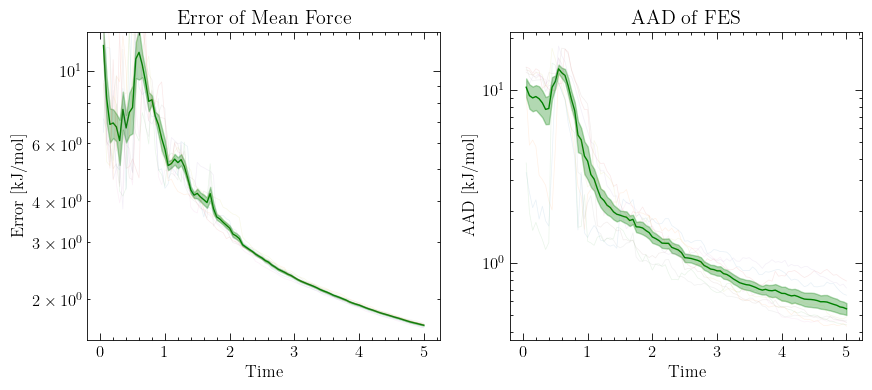

In [4]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=True)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f}")
plt.show()


### Exploration simulation

In [6]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":100_000, "metad_height":5, "metad_width":0.2, "biasfactor":500, "len_error_list":25})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class1D.MFI1D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")       


Simulation 1 (exists) | Final Error: Aofe = 8.2559, AAD = 2.6631
Simulation 2 (exists) | Final Error: Aofe = 8.1307, AAD = 4.0266
Simulation 3 (exists) | Final Error: Aofe = 7.4771, AAD = 4.5219
Simulation 4 (exists) | Final Error: Aofe = 8.3535, AAD = 5.4044
Simulation 5 (exists) | Final Error: Aofe = 7.6278, AAD = 3.9391
--- Mean of final AAD: 4.1110
Simulation 6 (exists) | Final Error: Aofe = 7.4572, AAD = 3.7945
Simulation 7 (exists) | Final Error: Aofe = 8.0570, AAD = 6.1577
Simulation 8 (exists) | Final Error: Aofe = 7.9787, AAD = 6.1853
Simulation 9 (exists) | Final Error: Aofe = 8.2047, AAD = 3.6610
Simulation 10 (exists) | Final Error: Aofe = 7.8493, AAD = 3.0651
--- Mean of final AAD: 4.3419
Simulation 11 (exists) | Final Error: Aofe = 8.0291, AAD = 3.3882
Simulation 12 (exists) | Final Error: Aofe = 8.2070, AAD = 3.7135
Simulation 13 (exists) | Final Error: Aofe = 8.5080, AAD = 3.3008
Simulation 14 (exists) | Final Error: Aofe = 7.9865, AAD = 7.2148
Simulation 15 (exists) | 

Mean Final AAD: 4.8487 +- 0.1550


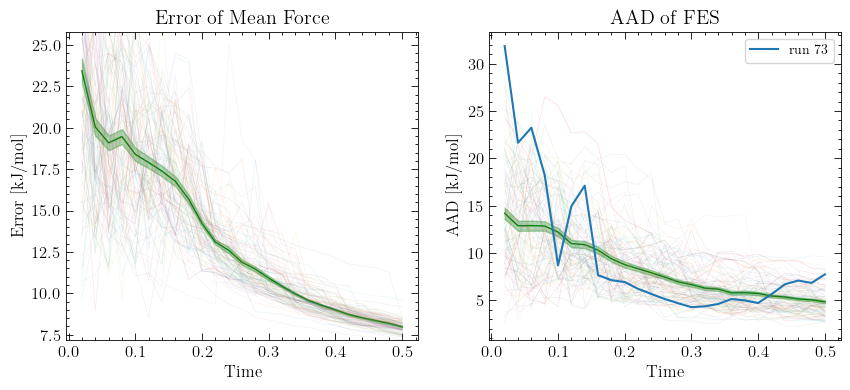

In [7]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}")

plt.plot(t, aad_collection[37-1], label="run 73")
plt.legend(fontsize=10)
plt.show()


In [46]:
# # Plot all exploration simulations to find a representative one to use for metad stage
# t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
# t = t_collection[0]

# for j in range(1, 21):
    
#     time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=False)
#     plt.subplot(1,2,1) 
#     for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
#     plt.subplot(1,2,2)
#     for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)    
    
#     for jj in range((j-1)*5, (j)*5):
        
#         print(f"Simulation {jj+1}", end=" | ")
        
#         plt.subplot(1,2,1)
#         plt.plot(t, aofe_collection[jj], label=f"{jj+1}", alpha=0.5)
#         plt.subplot(1,2,2)
#         plt.plot(t, aad_collection[jj], label=f"{jj+1}", alpha=0.5)
    
#     print("")    
#     plt.legend(fontsize=10)
#     plt.yscale("log")
#     plt.show() 
                                                                                                        

Final Error: Aofe = 8.1852, AAD = 4.6062
MIN(FES+Bias) = 94.3283, MIN(Z+Bias) = 96.7627


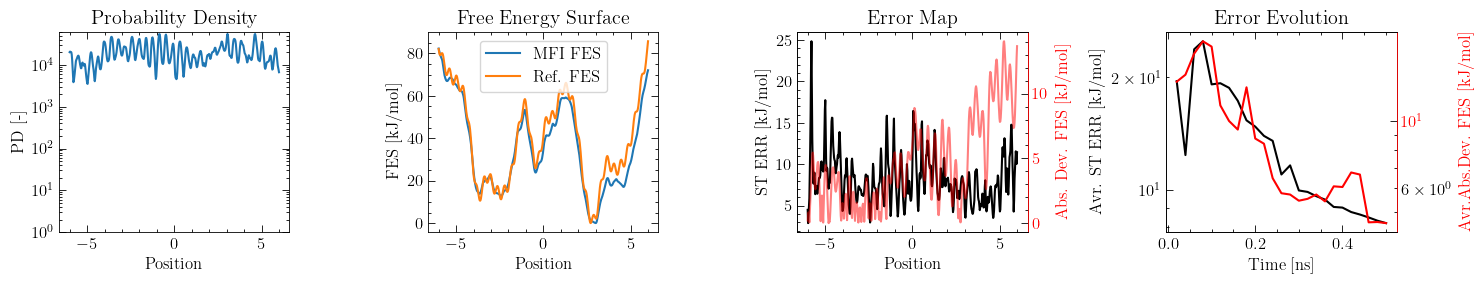

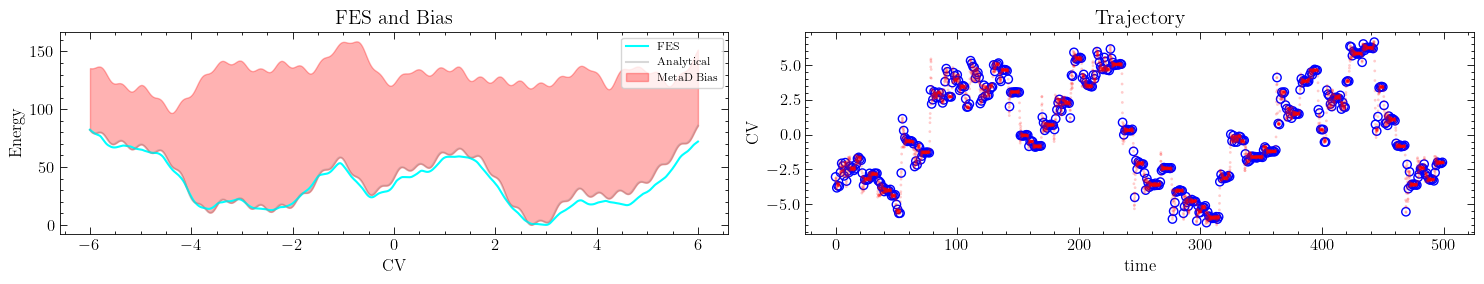

In [8]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
# new_params.update({"ID":"_expl_test", "len_error_list":25})
# new_params.update({"simulation_steps": 100_000, "metad_height":5, "metad_width":0.2, "biasfactor":500})
new_params.update({"save_error_progression":False, "save_force_terms":False})
new_params.update({"ID":"_expl_80", "len_error_list":25})

MFI_expl = MFI_class1D.MFI1D(**new_params)
# MFI_expl.run_simulation()   ########################
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(MFI_expl.y + MFI_expl.Bias):.4f}")
MFI_expl.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI_expl.grid, fes=MFI_expl.FES, metad_bias=MFI_expl.Bias, position=MFI_expl.position, hills=MFI_expl.hills, y=MFI_expl.y )
t_expl, v_expl, aofe_expl, aad_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES


### 2nd Stage - Run MetaD simulation

In [65]:
## test metad simulation

# metad_sim_params = {**default_params}
# metad_sim_params.update({"simulation_steps":900_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
# metad_sim_params.update({"metad_height":1, "metad_width":0.1, "biasfactor":5, "Bias_sf":1.03, "gaus_filter_sigma":2})
# metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})

# i_sim = 9
# sim_ID = f"_metad_{i_sim}"
# metad_sim_params.update({"ID":sim_ID})

# MFI_metad = MFI_class1D.MFI1D(**metad_sim_params)
# MFI_metad.make_external_bias(FES=fes_expl)
# # MFI_metad.run_simulation()
# MFI_metad.analyse_data()

# MFI_metad.plot_results()
# lib1.plot_FES_Bias_and_Traj(grid=MFI_metad.grid, fes=MFI_metad.FES, metad_bias=MFI_metad.Bias, static_bias=MFI_metad.Bias_static, position=MFI_metad.position, hills=MFI_metad.hills, y=MFI_metad.y )

# plt.figure(figsize=(10,10))

# plt.plot(grid, MFI_metad.FES, label="FES");


In [9]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":900_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
# metad_sim_params.update({"metad_height":2, "metad_width":0.1, "biasfactor":10, "Bias_sf":1, "gaus_filter_sigma":None})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class1D.MFI1D(**metad_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): 
            MFI_metad.make_external_bias(FES=fes_expl)
            MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 1.7141, AAD = 0.7313
Simulation 2 (exists) | Final Error: Aofe = 1.7499, AAD = 0.7991
Simulation 3 (exists) | Final Error: Aofe = 1.7467, AAD = 0.6108
Simulation 4 (exists) | Final Error: Aofe = 1.7250, AAD = 0.8610
Simulation 5 (exists) | Final Error: Aofe = 1.7370, AAD = 0.6123
--- Mean of final AAD: 0.7229
Simulation 6 (exists) | Final Error: Aofe = 1.7456, AAD = 0.7965
Simulation 7 (exists) | Final Error: Aofe = 1.7214, AAD = 1.0779
Simulation 8 (exists) | Final Error: Aofe = 1.7538, AAD = 0.7663
Simulation 9 (exists) | Final Error: Aofe = 1.7470, AAD = 0.9804
Simulation 10 (exists) | Final Error: Aofe = 1.7451, AAD = 0.6299
--- Mean of final AAD: 0.7865
Simulation 11 (exists) | Final Error: Aofe = 1.7331, AAD = 0.7731
Simulation 12 (exists) | Final Error: Aofe = 1.7189, AAD = 0.9767
Simulation 13 (exists) | Final Error: Aofe = 1.7391, AAD = 0.7040
Simulation 14 (exists) | Final Error: Aofe = 1.7306, AAD = 0.7085
Simulation 15 (exists) | 

Mean Final AAD: 0.8378 +- 0.0198


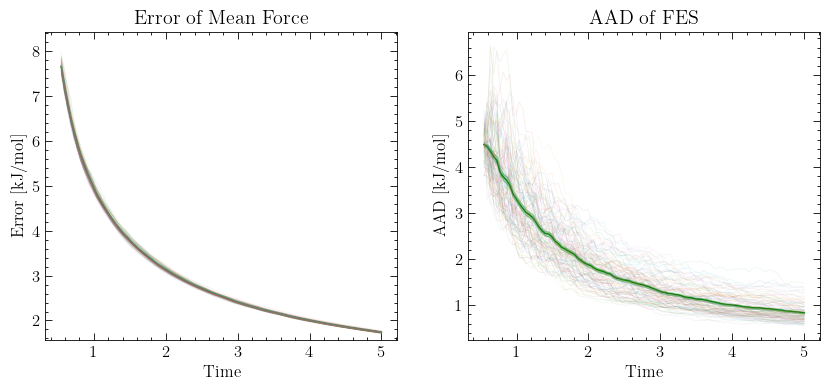

In [10]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f}")
plt.show()

### 2nd Stage - Run 2x MetaD simulations

In [13]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class1D.MFI1D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, aofe, aad = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 1.4191, AAD = 0.6443
Analysis 2 (exists) | Final Error: Aofe = 1.4286, AAD = 0.6055
Analysis 3 (exists) | Final Error: Aofe = 1.4375, AAD = 0.5652
Analysis 4 (exists) | Final Error: Aofe = 1.4258, AAD = 0.7366
Analysis 5 (exists) | Final Error: Aofe = 1.4386, AAD = 0.6395
Analysis 6 (exists) | Final Error: Aofe = 1.4097, AAD = 0.7014
Analysis 7 (exists) | Final Error: Aofe = 1.4158, AAD = 0.5693
Analysis 8 (exists) | Final Error: Aofe = 1.4464, AAD = 0.4789
Analysis 9 (exists) | Final Error: Aofe = 1.4280, AAD = 0.5709
Analysis 10 (exists) | Final Error: Aofe = 1.4108, AAD = 0.6510
Analysis 11 (exists) | Final Error: Aofe = 1.4410, AAD = 0.9501
Analysis 12 (exists) | Final Error: Aofe = 1.4275, AAD = 0.5606
Analysis 13 (exists) | Final Error: Aofe = 1.4285, AAD = 0.7065
Analysis 14 (exists) | Final Error: Aofe = 1.4321, AAD = 0.9281
Analysis 15 (exists) | Final Error: Aofe = 1.4205, AAD = 0.8369
Analysis 16 (exists) | Final Error: Aofe = 1.4326

Mean Final AAD: 0.7000 +- 0.0190


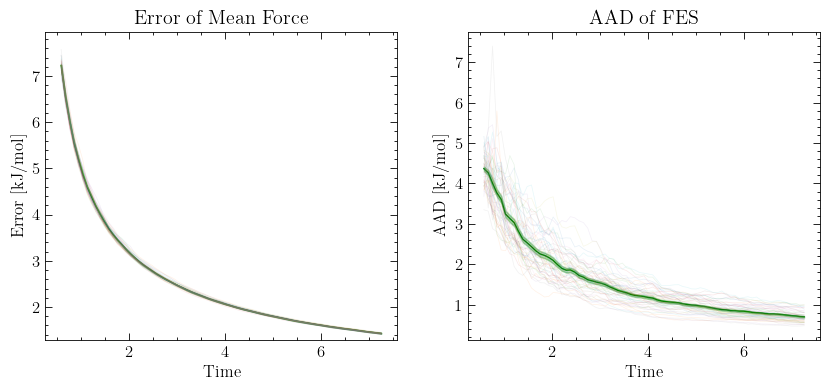

In [14]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f}")
plt.show()

### 2nd Stage - Run 3x MetaD simulations

In [102]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1);

In [72]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 3
parallel_efficiency = 0.667

for n_camp in range(1, 34):
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class1D.MFI1D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, aofe, aad = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.2473, AAD = 0.4777
Analysis 2 | Final Error: Aofe = 1.2428, AAD = 0.6526
Analysis 3 | Final Error: Aofe = 1.2407, AAD = 0.7549
Analysis 4 | Final Error: Aofe = 1.2416, AAD = 0.6245
Analysis 5 | Final Error: Aofe = 1.2494, AAD = 0.4373
Analysis 6 | Final Error: Aofe = 1.2562, AAD = 0.4832
Analysis 7 | Final Error: Aofe = 1.2321, AAD = 0.6415
Analysis 8 | Final Error: Aofe = 1.2640, AAD = 0.5440
Analysis 9 | Final Error: Aofe = 1.2557, AAD = 0.7443
Analysis 10 | Final Error: Aofe = 1.2384, AAD = 0.7520
Analysis 11 | Final Error: Aofe = 1.2465, AAD = 0.6868
Analysis 12 | Final Error: Aofe = 1.2397, AAD = 0.7280
Analysis 13 | Final Error: Aofe = 1.2422, AAD = 0.5406
Analysis 14 | Final Error: Aofe = 1.2346, AAD = 0.7578
Analysis 15 | Final Error: Aofe = 1.2459, AAD = 0.8255
Analysis 16 | Final Error: Aofe = 1.2353, AAD = 0.6908
Analysis 17 | Final Error: Aofe = 1.2440, AAD = 0.4580
Analysis 18 | Final Error: Aofe = 1.2466, AAD = 0.7395
Analysis 19 | Final

Mean Final AAD: 0.6380 +- 0.0230


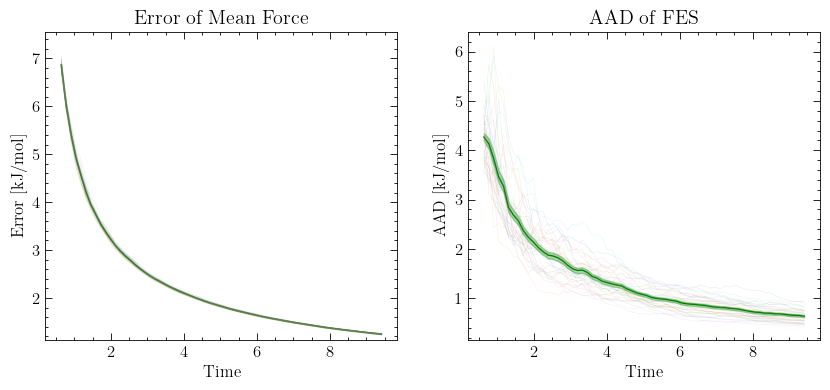

In [73]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage - Run 4x MetaD simulations

In [74]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class1D.MFI1D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



Analysis 1 | Final Error: Aofe = 1.2645, AAD = 0.6286
Analysis 2 | Final Error: Aofe = 1.2614, AAD = 0.7990
Analysis 3 | Final Error: Aofe = 1.2575, AAD = 0.6453
Analysis 4 | Final Error: Aofe = 1.2695, AAD = 0.4760
Analysis 5 | Final Error: Aofe = 1.2589, AAD = 0.6645
Analysis 6 | Final Error: Aofe = 1.2685, AAD = 0.6866
Analysis 7 | Final Error: Aofe = 1.2672, AAD = 0.7347
Analysis 8 | Final Error: Aofe = 1.2509, AAD = 0.9300
Analysis 9 | Final Error: Aofe = 1.2594, AAD = 0.7511
Analysis 10 | Final Error: Aofe = 1.2542, AAD = 0.7897
Analysis 11 | Final Error: Aofe = 1.2573, AAD = 0.7592
Analysis 12 | Final Error: Aofe = 1.2586, AAD = 0.8316
Analysis 13 | Final Error: Aofe = 1.2666, AAD = 0.4708
Analysis 14 | Final Error: Aofe = 1.2585, AAD = 0.7026
Analysis 15 | Final Error: Aofe = 1.2630, AAD = 0.7393
Analysis 16 | Final Error: Aofe = 1.2602, AAD = 0.4948
Analysis 17 | Final Error: Aofe = 1.2428, AAD = 0.8807
Analysis 18 | Final Error: Aofe = 1.2675, AAD = 0.5727
Analysis 19 | Final

Mean Final AAD: 0.7229 +- 0.0263


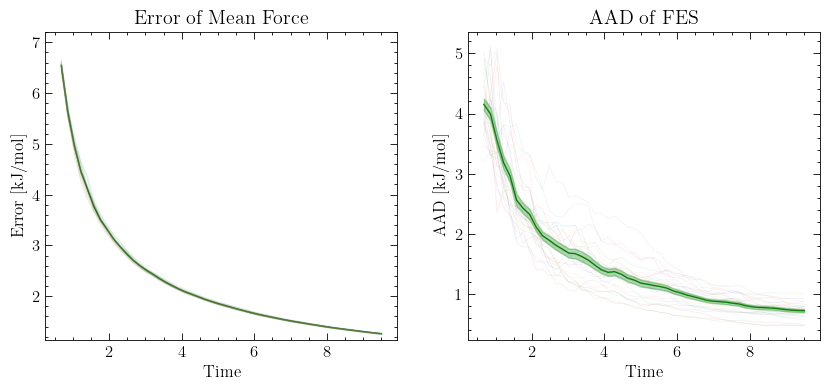

In [75]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [76]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class1D.MFI1D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.1631, AAD = 0.6759
Analysis 2 | Final Error: Aofe = 1.1598, AAD = 0.6743
Analysis 3 | Final Error: Aofe = 1.1711, AAD = 0.4785
Analysis 4 | Final Error: Aofe = 1.1673, AAD = 0.6951
Analysis 5 | Final Error: Aofe = 1.1624, AAD = 0.8928
Analysis 6 | Final Error: Aofe = 1.1569, AAD = 0.8178
Analysis 7 | Final Error: Aofe = 1.1575, AAD = 0.7190
Analysis 8 | Final Error: Aofe = 1.1573, AAD = 0.9765
Analysis 9 | Final Error: Aofe = 1.1644, AAD = 0.5141
Analysis 10 | Final Error: Aofe = 1.1594, AAD = 0.6638
Analysis 11 | Final Error: Aofe = 1.1576, AAD = 0.5606
Analysis 12 | Final Error: Aofe = 1.1575, AAD = 0.6829
Analysis 13 | Final Error: Aofe = 1.1775, AAD = 0.8499
Analysis 14 | Final Error: Aofe = 1.1759, AAD = 0.5634
Analysis 15 | Final Error: Aofe = 1.1682, AAD = 0.7921
Analysis 16 | Final Error: Aofe = 1.1636, AAD = 0.8026


Mean Final AAD: 0.6380 +- 0.0230


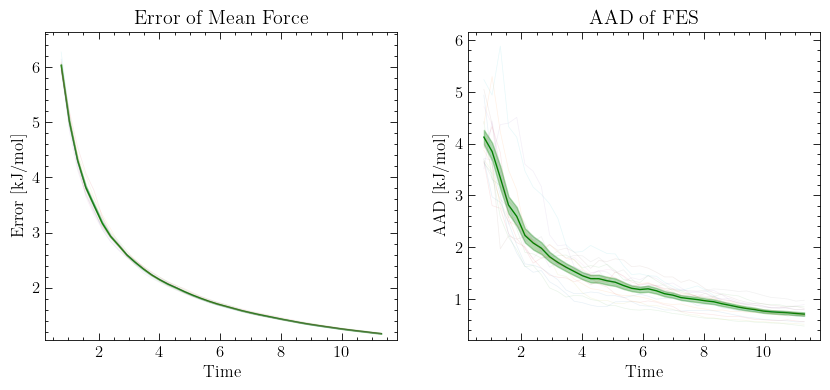

In [77]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [78]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class1D.MFI1D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 | Final Error: Aofe = 1.0612, AAD = 0.6641
Analysis 2 | Final Error: Aofe = 1.0609, AAD = 0.5773
Analysis 3 | Final Error: Aofe = 1.0580, AAD = 0.8381
Analysis 4 | Final Error: Aofe = 1.0481, AAD = 0.8591
Analysis 5 | Final Error: Aofe = 1.0439, AAD = 0.8600
Analysis 6 | Final Error: Aofe = 1.0502, AAD = 0.6706
Analysis 7 | Final Error: Aofe = 1.0509, AAD = 0.7104
Analysis 8 | Final Error: Aofe = 1.0720, AAD = 0.7707
Analysis 9 | Final Error: Aofe = 1.0639, AAD = 0.8722
Analysis 10 | Final Error: Aofe = 1.0596, AAD = 0.9544


Mean Final AAD: 0.6380 +- 0.0230


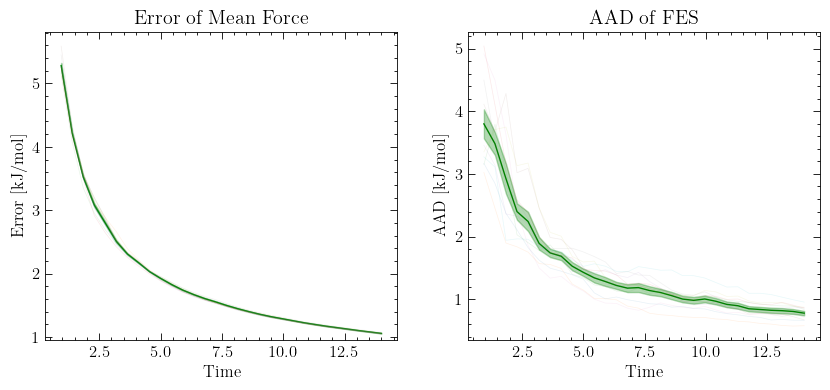

In [79]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [11]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = max(5, int(len(data)/20))    
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data

<Figure size 1000x400 with 0 Axes>

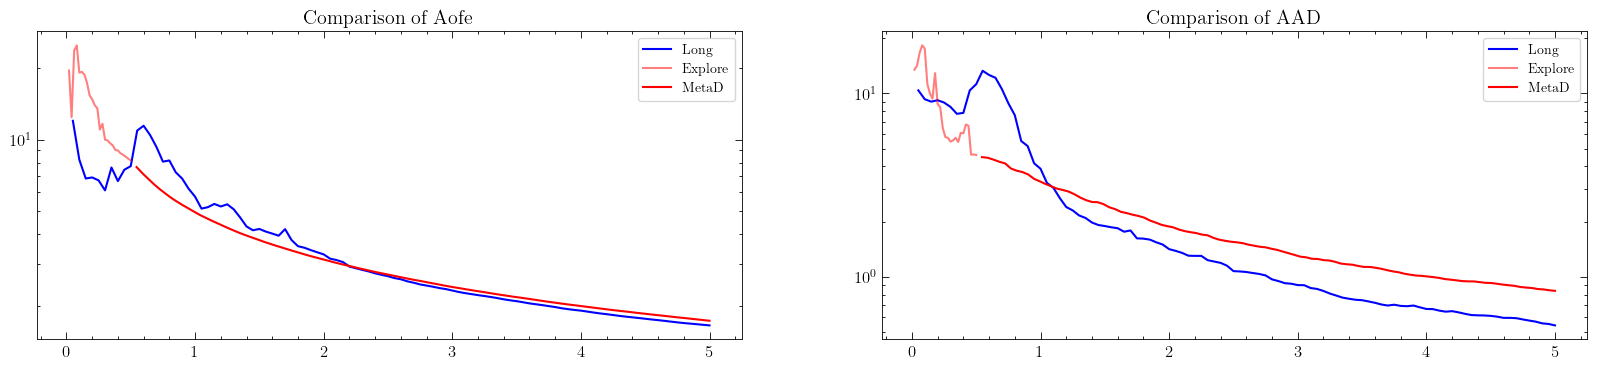

In [12]:
plt.figure(figsize=(10,4))
plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,2,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2 (e=0.75)", color="orange")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3(e=0.67)", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4 (e=0.5)", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6 (e=0.4)", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx10 (e=0.3)", color="grey")
plt.legend(fontsize=10); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); #plt.plot([time_long[-1],10], [mean_aad_long[-1],mean_aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="MetaD", color="red"); #plt.plot([time_metad[-1],10], [mean_aad_metad[-1],mean_aad_metad[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, sf(mean_aad_metadx2), label="MetaDx2 (e=0.75)", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3 (e=0.67)", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4 (e=0.5)", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6 (e=0.4)", color="aquamarine")
# plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx10 (e=0.3)", color="grey")

# plt.ylim(0.38, 3)
# plt.xlim(0, 10)
plt.yscale("log"); 
plt.legend(fontsize=10); plt.title("Comparison of AAD"); plt.show()

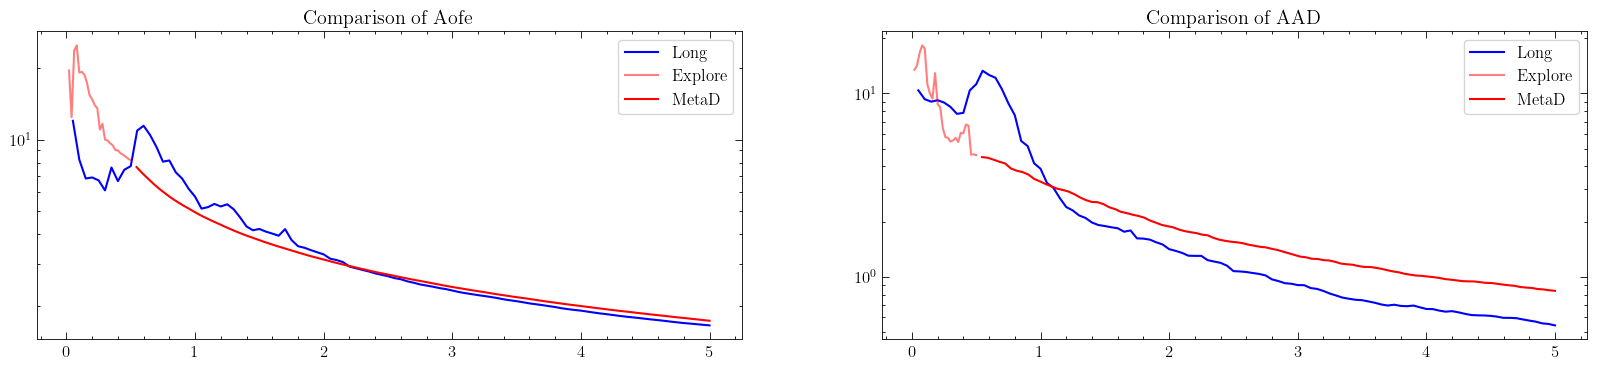

In [14]:
plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,2,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(time_long, mean_aad_long, label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_aad_metad, label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, mean_aad_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx3, mean_aad_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_aad_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_aad_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx6", color="grey")

# plt.ylim(0.38, 0.6)
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); plt.show()

lib1.save_pkl([time_long, mean_ofe_long, mean_aad_long, t_expl, aofe_expl, aad_expl, time_metad, mean_ofe_metad, mean_aad_metad], "/home/ucecabj/Desktop/temp_error_progression.pkl")
